In [29]:
import os.path as osp
import argparse
import numpy as np
import torch
import smplx
import glob
import cv2
import os
import pyrender
import trimesh
import json
from tqdm import tqdm
import pickle
import scipy as sp
import igl
import robust_laplacian

import os.path as osp
import argparse
import numpy as np
import torch
import smplx
import glob
import cv2
import os
import pyrender
import trimesh
import json
from tqdm import tqdm

In [30]:
with open('../00122/Outer/Take9/SMPLX/mesh-f00011_smplx.pkl', 'rb') as file:
    smplx_data = pickle.load(file)
smplx_data

{'global_orient': array([ 0.00492813,  1.6237236 , -0.0699005 ], dtype=float32),
 'body_pose': array([-4.19760346e-02,  9.74555463e-02,  1.90463886e-01, -7.47566670e-02,
        -7.21446872e-02, -1.57268777e-01, -4.56898585e-02,  4.43277182e-03,
         5.37694916e-02, -6.97312132e-02,  8.66318271e-02,  9.14673135e-02,
        -1.26157841e-02, -6.44140169e-02, -1.91337466e-02,  5.14160208e-02,
        -1.75482202e-02,  8.12641811e-03,  1.33622453e-01,  5.47491647e-02,
        -1.69454706e-05,  1.37154654e-01, -3.88579182e-02,  1.61871758e-05,
         8.12471882e-02, -8.73514544e-03,  2.21590884e-02,  1.58502371e-05,
         1.57070062e-05,  1.54597165e-05,  1.54723148e-05,  1.39889626e-05,
        -1.51485538e-05, -1.13553563e-02, -4.63176444e-02, -6.14181906e-02,
        -5.00713438e-02,  2.19184086e-01, -1.77930251e-01, -2.58259997e-02,
        -1.98528439e-01,  1.84636593e-01,  7.81371593e-02, -1.03415944e-01,
         8.63157436e-02, -8.68193135e-02,  5.43496907e-02, -8.56566191

In [31]:
with open('/home/yeyiqi/Documents/repos/GaussianAvatar/assets/smpl_files/smplx/SMPLX_NEUTRAL.pkl', 'rb') as file:
    model_data = pickle.load(file, encoding='latin1')
model_data.keys()

dict_keys(['dynamic_lmk_bary_coords', 'hands_componentsl', 'ft', 'lmk_faces_idx', 'f', 'J_regressor', 'hands_componentsr', 'kintree_table', 'hands_coeffsr', 'joint2num', 'hands_meanl', 'lmk_bary_coords', 'weights', 'posedirs', 'dynamic_lmk_faces_idx', 'part2num', 'vt', 'hands_meanr', 'hands_coeffsl', 'v_template', 'shapedirs'])

In [32]:
body_model_param = {
    'betas': np.expand_dims(smplx_data['betas'],0),
    'expression': np.expand_dims(smplx_data['expression'],0),
    'transl': np.expand_dims(smplx_data['transl'],0),
    'global_orient': np.expand_dims(smplx_data['global_orient'], 0),
    'body_pose': np.expand_dims(smplx_data['body_pose'], 0),
    'jaw_pose': np.expand_dims(smplx_data['jaw_pose'], 0),
    'leye_pose': np.expand_dims(smplx_data['leye_pose'], 0),
    'reye_pose': np.expand_dims(smplx_data['reye_pose'], 0),
    'left_hand_pose': np.expand_dims(smplx_data['left_hand_pose'], 0),
    'right_hand_pose': np.expand_dims(smplx_data['right_hand_pose'], 0)
}

In [33]:
body_model_param_tensor = {
    key: torch.tensor(body_model_param[key]) for key in body_model_param.keys()
}

In [34]:
model_folder = '/home/yeyiqi/Documents/repos/GaussianAvatar/assets/smpl_files'
model_type = 'smplx'

kwargs = dict(
        gender='neutral',
        num_betas=10,
        use_face_contour=True,
        num_pca_comps=12,
        use_pca=True,
        batch_size=1,
        ext = 'pkl'
)
model = smplx.create(
    model_path = model_folder,
    model_type = model_type,
    **kwargs
)

In [35]:
output = model(**body_model_param_tensor)

torch.Size([1, 55, 3, 3])


In [36]:
vertices = output.vertices.detach().cpu().numpy().squeeze()
joints = output.joints.detach().cpu().numpy().squeeze()
faces = model.faces

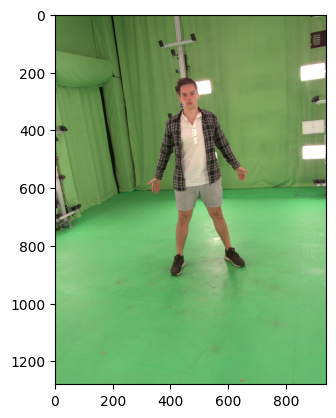

In [37]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
image = cv2.imread('/home/yeyiqi/Documents/WD/00122/Outer/Take9/Capture/0076/images/capture-f00011.png')
plt_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(plt_image)

In [38]:
def render_pose(img, camera, vertices, faces, return_mask=False):
    pyrender2opencv = np.array([[1.0, 0, 0, 0],
                                [0, -1, 0, 0],
                                [0, 0, -1, 0],
                                [0, 0, 0, 1]])
    base_color = (1.0, 193/255, 193/255, 1.0)
    material = pyrender.MetallicRoughnessMaterial(
        metallicFactor=0.1,
        roughnessFactor=0.4,
        alphaMode='OPAQUE',
        emissiveFactor=(0.2, 0.2, 0.2),
        baseColorFactor=(0.7, 0.7, 0.7, 1)
    )
    body_trimesh = trimesh.Trimesh(vertices, faces, process=False)
    body_mesh = pyrender.Mesh.from_trimesh(body_trimesh, material=material)
    light = pyrender.DirectionalLight(color=np.ones(3), intensity=2.0)
    cam_pose = pyrender2opencv @ np.eye(4)
    scene = pyrender.Scene(bg_color=[0.0, 0.0, 0.0, 0.0], ambient_light=(0.3, 0.3, 0.3))
    scene.add(camera, pose=cam_pose)
    scene.add(light, pose=cam_pose)
    scene.add(body_mesh, 'mesh')
    r = pyrender.OffscreenRenderer(viewport_width=img.shape[1],
                                  viewport_height=img.shape[0],
                                  point_size=1.0)
    color, _ = r.render(scene, flags=pyrender.RenderFlags.RGBA)
    color = color.astype(np.float32) / 255.0

    valid_mask = (color[:, :, -1] > 0)[:, :, np.newaxis]
    img = img / 255.0
    
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    output_img = (color[:, :, :] * valid_mask + (1 - valid_mask) * img)

    img = (output_img * 255).astype(np.uint8)
    if return_mask:
        return img, valid_mask, (color * 255).astype(np.uint8)
    return img

In [39]:
with open('/home/yeyiqi/Documents/WD/00122/Outer/Take9/Capture/cameras.pkl', 'rb') as file:
    cam_info = pickle.load(file)
cam_info

{'0004': {'intrinsics': array([[1.11851456e+03, 3.55271368e-13, 4.55050594e+02],
         [0.00000000e+00, 1.11838198e+03, 6.26902072e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'extrinsics': array([[ 0.99621741, -0.08682953, -0.00339258,  0.25956238],
         [-0.08433436, -0.97552417,  0.20307711,  1.1368941 ],
         [-0.02094263, -0.20202285, -0.97915687,  3.07406384]])},
 '0028': {'intrinsics': array([[1.11937088e+03, 2.13162821e-14, 4.50860062e+02],
         [0.00000000e+00, 1.11941311e+03, 6.33447886e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'extrinsics': array([[ 0.00557261, -0.07967603,  0.99680523,  0.29362592],
         [-0.21553372, -0.9734868 , -0.07660722,  1.119606  ],
         [ 0.9764805 , -0.21441824, -0.02259774,  3.13256862]])},
 '0052': {'intrinsics': array([[1.11749824e+03, 7.10542736e-14, 4.42994563e+02],
         [0.00000000e+00, 1.11751825e+03, 6.31881148e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00

In [40]:
extrin = cam_info['0076']['extrinsics']
intrin = cam_info['0076']['intrinsics']
R = extrin[:3,:3]
T = extrin[:3,3]

In [41]:
vertices_projected, _ = cv2.projectPoints(vertices.T, R, T, intrin, np.zeros(5))
vertices_projected.shape

(10475, 1, 2)

/tmp/ipykernel_100145/157716030.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


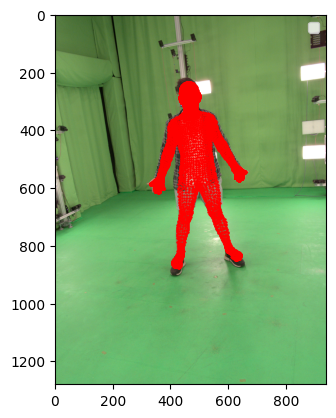

In [42]:
vertices_projected = vertices_projected.squeeze()
plt.imshow(plt_image)
plt.scatter(vertices_projected[:, 0], vertices_projected[:, 1], c='red', s=0.5)
plt.legend()
plt.axis()
plt.show()

In [43]:
from PIL import Image

In [49]:
image = Image.open('/home/yeyiqi/Documents/WD/00122/Outer/Take9/Capture/0076/masks/mask-f00011.png')
image = np.array(image)
for i in range(len(image)):
    for j in range(len(image[0])):
        if image[i,j] != 0:
            print(image[i,j])

255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
255
